Age / Exposure Tracers for Bloom Analysis
==

This is a retake on the early analysis of DWAQ-based tracers, but using an
online-coupled DFM run.

v02: Add temperature back in, initialized from AVHRR.

First go revealed that
* the ocean BC is likely too cold due to forcing from ROMS depth-averaged
  temperature and grid-geometry related instability that gives ocean BC undue influence.
* Air temperature forcing is too variable at daily time scales and too warm.

Replaced ocean BC from ROMS with data from NDBC SF Buoy



Notes from v01:
The 2022-08-04 to 2022-08-30 run took 2.2 days, about 11x realtime.
This version includes upward swimming at 0, 10, and 20 m/d, and disables temperature.

Trying for bloom_tracer_v08, and all ranks get "flownode mismatches". Vague recollection that 
this can be caused by renumbering changes between the run being restarted and the new run.

2024-07-11: Consider broader IC.

In [1]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")

In [2]:
import os, glob, shutil
import datetime
import six
import xarray as xr
import pandas as pd
import re

from stompy.spatial import field, proj_utils
from stompy import utils
from stompy.plot import plot_wkb, plot_utils
import xarray as xr
import stompy.plot.cmap as scmap
from scipy import ndimage

import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
import stompy.model.delft.io as dio

from stompy.model import unstructured_diffuser
from stompy.grid import unstructured_grid
from stompy.io.local import noaa_coops
from shapely import geometry
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

In [3]:
import bloom_common
import insitu_temperature

DFM-based Runs
==

In [4]:
# restart files every 10 days, plus a restart file on 2022-08-01.
# speed was 85x realtime on 16 cores.
# Forcing should all be okay to copy/link for restarts.

if 0: # Check on map and rst output:
    dfm_base_run_dir="dfm_spinup"
    map_fn=os.path.join(dfm_base_run_dir,
                        "DFM_OUTPUT_wy2022_bloom_16layer",
                        "wy2022_bloom_16layer_0000_20220501_000000_map.nc")
    rst_fn=os.path.join(dfm_base_run_dir,
                        "DFM_OUTPUT_wy2022_bloom_16layer",
                        "wy2022_bloom_16layer_0000_20220801_000000_rst.nc")
    
    map_ds=xr.open_dataset(map_fn)
    rst_ds=xr.open_dataset(rst_fn)

grid = unstructured_grid.UnstructuredGrid.read_dfm("dfm_spinup/sfei_v20_net.nc")
shore_poly = grid.boundary_polygon()

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3212664407.249216, 15 potential interiors


In [5]:
# For testing:
#grid = unstructured_grid.UnstructuredGrid.read_dfm("dfm_spinup/sfei_v20_net.nc")
#run_start = np.datetime64("2022-08-02 12:00")

def get_temperature_on_grid_avhrr(grid, run_start, temp_database="RS_temperature/extrapolated_avhrr.nc"):
    ds=xr.open_dataset(temp_database)
    
    from stompy.spatial import field
    tidx1=np.searchsorted(ds.time.values, run_start)
    
    if tidx1>0:
        tidx0=tidx1-1
        alpha = (run_start - ds.time.values[tidx0])/(ds.time.values[tidx1]-ds.time.values[tidx0])
        F = ( (1-alpha)*ds.extrap_spatiotemporal_mu.isel(time=tidx0).values
               + alpha*ds.extrap_spatiotemporal_mu.isel(time=tidx1).values)
    else:
        F = ds.extrap_spatiotemporal_mu.isel(time=tidx1).values
        
    fld=field.SimpleGrid(extents=[ds.longitude.values.min(), ds.longitude.values.max(),
                                  ds.latitude.values.min(), ds.latitude.values.max()],
                         F=F)
    grid_ll = proj_utils.mapper('EPSG:26910','WGS84')(grid.cells_centroid())
    grid_ll[:,0] += 360.0 # positive west longitude
    F_on_grid=fld(grid_ll)

    #  use grid diffusion to fill in gaps.
    ud = unstructured_diffuser.Diffuser(grid)
    for c in np.nonzero(np.isfinite(F_on_grid))[0]:
        ud.set_dirichlet(F_on_grid[c],cell=c)
    F_filled = ud.compute()

    return F_filled

def get_temperature_on_grid_acspo(grid, run_start, temp_database="RS_temperature/supercollated_data_v00.nc"):
    # database assumed to be in lat/lon, grid in UTM.
    ds=xr.open_dataset(temp_database)
        
    tidx1=utils.nearest(ds.time.values, run_start) # both UTC. database is daily composite, centered on 12:00

    if ds.latitude.values[1] < ds.latitude.values[0]:
        lat_slice=slice(None,None,-1)
    else:
        lat_slice=slice(None)
    F = ds.sea_surface_temperature.isel(time=tidx1,latitude=lat_slice).values
    fld=field.SimpleGrid(extents=[ds.longitude.values.min(), ds.longitude.values.max(),
                                  ds.latitude.values.min(), ds.latitude.values.max()],
                         F=F)
    grid_ll = proj_utils.mapper('EPSG:26910','WGS84')(grid.cells_centroid())
    if ds.longitude.values.min()>0 and grid_ll[:,0].min()<0:
        grid_ll[:,0] += 360.0 # positive west longitude
    F_on_grid=fld.interpolate(grid_ll,interpolation='nearest')

    #  use grid diffusion to fill in gaps.
    ud = unstructured_diffuser.Diffuser(grid)
    for c in np.nonzero(np.isfinite(F_on_grid))[0]:
        ud.set_dirichlet(F_on_grid[c],cell=c)
    F_filled = ud.compute()

    return F_filled

In [6]:
# SF Buoy data for ocean BC:
#six.moves.reload_module(insitu_temperature)
from insitu_temperature import sf_buoy_data

In [7]:
# Replace met forcing - I don't have other humidity or cloudiness data, so will just
# overwrite the temperature field.
import met_updater
six.moves.reload_module(met_updater)
from met_updater import MetUpdater

In [19]:
# Had to resurrect this from 
# https://github.com/rustychris/wy2022_bloom/blob/9868ba1b0e71029f5be004eeebcdeefc99ebfa3f/run_dfm_bloom_tracers_v02.ipynb
# May 17
# No more commits until I nuked it 6/24.

alameda_clip=(555140, 567000, 4174362, 4185757)
southbay_clip=(552286, 581995, 4149265, 4185436)

def get_initial_chl_from_RS(clip=alameda_clip,plot=False,fix_log_bug=True):
    rs_chl_dir="/richmondvol1/lawrences/outputs_2022/07_reproject_3"
    scene="20220804_S3A_OL_NT_CHL_LOG10.img" # bloom not that obvious.
    #scene="20220805_S3B_OL_NT_CHL_LOG10.img" # lots of clouds
    #scene="20220806_S3B_OL_NT_CHL_LOG10.img" # lots of clouds
    #scene="20220807_S3A_OL_NT_CHL_LOG10.img" # decent, though getting late.
    rs_chl_fn=os.path.join(rs_chl_dir,scene)
    rs_chl_log10 = field.GdalGrid(rs_chl_fn)
    
    # clip and remove specks.
    
    valid = np.isfinite(rs_chl_log10.F)
    #valid = ndimage.binary_erosion(valid,iterations=1) # remove specks
    valid = valid & rs_chl_log10.polygon_mask(shore_poly) 
    rs_chl_log10.F[~valid]=np.nan
    rs_chl_log10.F = ndimage.median_filter(rs_chl_log10.F,size=3)
    rs_chl_log10.F[ rs_chl_log10.F<1.0 ] = np.nan
    
    # limit IC to within a bounding box
    if clip is not None:
        in_box = rs_chl_log10.xxyy_mask( clip )
        rs_chl_log10.F[ ~in_box ] = np.nan
    
    chl_IC = rs_chl_log10.copy()
    if fix_log_bug:
        chl_IC.F = 10**chl_IC.F
    else: # Isn't this wrong??
        chl_IC.F = chl_IC.F**10
    
    chl_IC.F[ np.isnan(chl_IC.F) ] = 0.0
    
    if plot: # extra plots
        fig,ax=plt.subplots()
        ax.set_adjustable('datalim')
    
        img0=rs_chl_log10.plot(cmap='gray',alpha=0.5)
        img0.set_clim(0,2)
    
        geo_bbox = geometry.box(bbox[0],bbox[2],bbox[1],bbox[3])
        plot_wkb.plot_wkb(geo_bbox,lw=0.8,ec='r',fc='none')
        img=rs_chl_log10.plot()
        #img.set_clim(0,2)
        plt.colorbar(img, label="log$_{10}$ chl")
        ax.axis((548224, 576581, 4158516, 4189141))
        
        plot_wkb.plot_wkb(shore_poly, ax=ax, fc='none',ec='k',lw=0.8)
        ax.xaxis.set_visible(0)
        ax.yaxis.set_visible(0)
        fig.subplots_adjust(left=0.04,right=0.94,top=0.98,bottom=0.04)
    
    return chl_IC

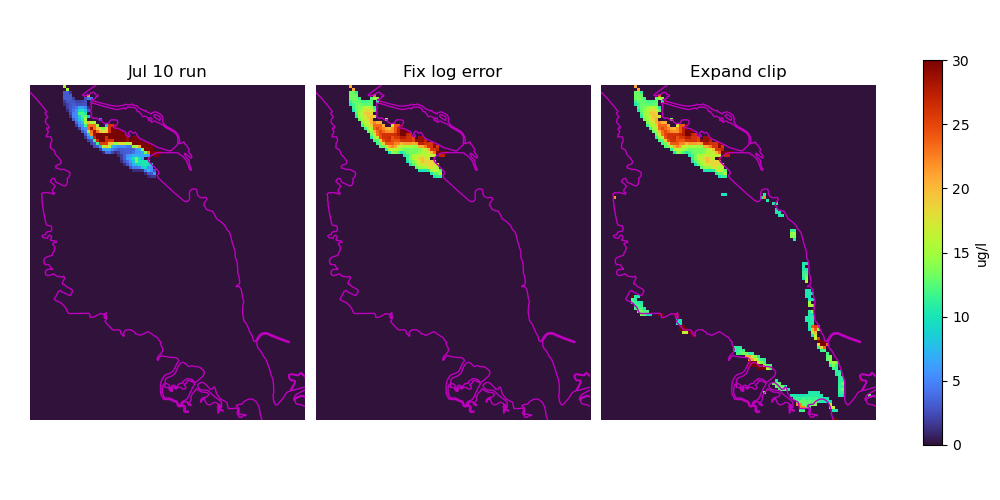

In [32]:
if 0: # Check issues with IC
    chl_orig  = get_initial_chl_from_RS(fix_log_bug=False)
    chl_fixed = get_initial_chl_from_RS(fix_log_bug=True)
    chl_sbclip = get_initial_chl_from_RS(fix_log_bug=True, clip=southbay_clip)
    
    fig,axs = plt.subplots(1,3,figsize=(10,5))
    
    for ax,chl in zip(axs, [chl_orig,chl_fixed, chl_sbclip]):
        coll = chl.plot(ax=ax,clim=[0,30],cmap='turbo')
        plot_wkb.plot_wkb(shore_poly,ec='m',fc='none',ax=ax)
        ax.axis('off')
        ax.axis(southbay_clip)
    axs[0].set_title('Jul 10 run')
    axs[1].set_title('Fix log error')
    axs[2].set_title('Expand clip')
    fig.subplots_adjust(right=0.97,left=0.03,wspace=0.04)
    plt.colorbar(coll,ax=axs,label='ug/l',fraction=0.05)
    chl_orig.F.sum(), chl_fixed.F.sum(), chl_sbclip.F.sum()

In [9]:
# First, get a basic restart going
import stompy.model.delft.waq_scenario as waq
from stompy.model.delft import custom_process
six.moves.reload_module(waq)
six.moves.reload_module(custom_process)

class ModelBase(custom_process.CustomProcesses,bloom_common.SFBRestartable):
    dwaq=True
    temperature=True
    
    kd_path="../Kd_2022/Kd_sentinel3_1h/Kd_sent3_20220801_20220901.nc"

    inputs_static=("/boisevol1/hpcshared/open_bay/hydro/full_res"
                   "/wy2022_r52184/sfb_dfm/inputs-static/")

    tracer_configs=[ dict(fall_velocity_m_s= -5.0/86400, release='uniform'),
                     dict(fall_velocity_m_s=-10.0/86400, release='uniform'),
                     dict(fall_velocity_m_s=0, release='uniform')
                   ]
                    
    seg_function_resolution=500.0 # [m] resolution when discretizing spatiotemporal parameter to cartesian grid.

    overwrite_tracers=False # true to copy/update restart file to re-initialize tracers
    overwrite_temperature=False # true to update temperature field from AVHRR 

    replace_ocean_temp_bc = True # Use SF Buoy water temp
    replace_met_bc = True
    
    def configure_general(self):
        bloom_common.configure_dfm_t141798()
                
        self.mdu['output','WaqInterval']="" # no need for DWAQ output
        self.dfm_bin_dir=os.path.join(os.environ['DELFT_SRC'],'bin')
        self.mpi_bin_dir=os.path.join(os.environ['DELFT_SRC'],'bin')

        # 2024-05-23: Getting "flownode mismatches", and this was 1. So trying 0...
        self.mdu['geometry','RenumberFlowNodes']=0
        
        # Some files have moved around, so update locations
        self.mdu['output','CrsFile' ] = os.path.join(self.inputs_static, "SB-observationcrosssection.pli")
        self.mdu['output','MapInterval' ] = 3600
        self.mdu['geometry','LandBoundaryFile'] = os.path.join(self.inputs_static,"deltabay.ldb")
        self.mdu['geometry','FixedWeirFile'] = os.path.join(self.inputs_static,"SBlevees_tdk.pli")
        self.mdu['geometry','AngLon'] = -121.0 # affects Qsun in heat budget

        # run_dfm_rs_chl for other entries that may have to be dropped.
        del self.mdu['waves','WaveNikuradse']

        if not self.temperature:
            self.mdu['physics','Temperature'] = 0 # and fix-up tracers below
        else:
            self.mdu['physics','Temperature'] = 5 # follows the dfm_spinup config
            self.mdu['physics','Dalton'] = -1 # use Cd for wind stress for convective heat flux
            self.mdu['physics','Stanton'] = -1 # use Cd for wind stress for evaporative heat flux

        # for non-restart this is handled by configure(), but restart doesn't call that.
        if self.dwaq is True:                                                                                              
            self.dwaq=dwaq.WaqOnlineModel(model=self)
            
    def set_bloom_tracers(self):
        self.my_tracers=[] # all of the new tracers, including multiple tracers for each entry of self.tracer_configs
        
        # I think the steps are
        #  1. add the tracer definitions to forcing data via appending/updating FlowFMold_bnd.ext
        #  2. add/overwrite the tracers in the restart file.
        
        tracers=[]

        def release_2d_func(xy,cfg): # vectorized on xy
            if 'release_poly' in cfg:
                release_poly = cfg['release_poly']
                in_poly = [release_poly.contains(geometry.Point(p)) for p in xy]
                value_2d = np.array(in_poly)
            elif cfg['release']=='rs_chl':
                # Default to clipping to original Alameda region
                release_raster = get_initial_chl_from_RS(plot=False,clip=cfg.get('release_clip',alameda_clip))
                value_2d = release_raster(xy)
                # raster may not be large enough to cover domain.
                value_2d[ np.isnan(value_2d) ] = 0.0
            elif cfg['release']=='uniform': # uniform releasee
                value_2d = np.ones(xy.shape[0],np.float64)
            else:
                raise Exception("Expected tracer to have some release configured")
            return value_2d
        
        for tracer_i,tracer_cfg in enumerate(self.tracer_configs):
            # Names must be <=10 characters!
            conc='conc' + str(tracer_i)

            # Drop complicated machinery for updating vertically variable RS scenes.
            # Even with swimming will use a mixed IC.
            def tracer_blob(rst_ds,values_cell_layer):
                # Dropped uniform tracer code.
                xy=np.c_[ rst_ds.FlowElem_xzw.values, rst_ds.FlowElem_yzw.values]

                value_2d = release_2d_func(xy,tracer_cfg)
                
                # mixed initial_condition
                values_cell_layer[:,:] = value_2d[:,None]
            def tracer_zero(rst_ds,values_cell_layer):
                values_cell_layer[:,:] = 0.0

            # Unsure of whether this is the right place to do settling, or if it should
            # be through DWAQ.
            tracers.append( dict(name=conc,func=tracer_blob,cfg=tracer_cfg))
            
            if tracer_cfg.get('agec',False):
                # basic age. For instantaneous release we know the answer,
                # but that will serve as a check once we attempt swimming.
                agec='agec' + str(tracer_i) # these are enabled depending on tracer_cfg
                self.custom_CART(conc=conc,age_conc=agec)
                tracers.append( dict(name=agec,func=tracer_zero,cfg=tracer_cfg))
                
            if tracer_cfg.get('depc',False):
                depc='depc' + str(tracer_i)
                self.custom_CART(conc=conc,age_conc=depc,partial="LocalDepth")
                tracers.append( dict(name=depc,func=tracer_zero,cfg=tracer_cfg))
                
            if tracer_cfg.get('radc',False):
                radc='radc' + str(tracer_i)
                self.custom_CART(conc=conc,age_conc=radc,partial='RadBot')
                tracers.append( dict(name=radc,func=tracer_zero,cfg=tracer_cfg))

        for tracer in tracers:
            # Initials don't really matter here as they are manually written to restart files.
            self.dwaq.substances[tracer['name']]=dwaq.Substance(initial=0)
            
        self.my_tracers=tracers
        # Adding the tracers to the ext file doesn't happen until copy_file_for_restart
        # likewise, will have to modify the restart files later.

    def update_restart_data(self):
        if self.overwrite_temperature:
            # setup global grid with temperature
            #self.temp_on_grid = get_temperature_on_grid_avhrr(self.grid, self.run_start)
            self.temp_on_grid = get_temperature_on_grid_acspo(self.grid, self.run_start)

        def modify_ic(rst_ds,**kw):
            if self.overwrite_tracers:
                for tracer in self.my_tracers:
                    name=tracer['name']
                    func=tracer['func']
                    self.log.info(f"Setting tracer {name} in restart file")
                    # mimic sa1 tracer
                    salt=rst_ds['sa1']
                    values=salt.values.copy() # ('time','nFlowElem','laydim')
                    values[...] = 0.0 # don't accidentally write salt data though
                    
                    # updates values in place.
                    func(rst_ds=rst_ds,values_cell_layer=values[0,:,:])
                    rst_ds[name]=salt.dims, values
                    for aname in ['coordinates','grid_mapping']:
                        if aname in salt.attrs:
                            rst_ds[name].attrs[aname]=salt.attrs[aname]
            if self.overwrite_temperature and self.temperature:
                name='tem1'
                temp=rst_ds[name]
                values=temp.values.copy() # ('time','nFlowElem','laydim')

                self.log.info(f"Setting initial temperature field based on AVHRR or ACSPO")
                
                # updates values in place.
                xy=np.c_[ rst_ds.FlowElem_xzw.values, rst_ds.FlowElem_yzw.values]
                cells = [self.grid.select_cells_nearest(pnt) for pnt in xy]
                cells=np.array(cells)
                temp_2d = self.temp_on_grid[cells]
                values[0,:,:] = temp_2d[:,None]
                rst_ds[name]=temp.dims, values
                for aname in ['coordinates','grid_mapping']:
                    if aname in temp.attrs:
                        rst_ds[name].attrs[aname]=temp.attrs[aname]
                
        self.modify_restart_data(modify_ic)
        
    def write_ocean_temperature_bc(self,fp_new,rec):   
        # presumably rec['FILENAME'] is in the bc_files folder, which might be shared.
        if self.replace_ocean_temp_bc:
            print("OVERWRITING OCEAN TEMPERATURE BC")
            temp_data = sf_buoy_data()
            # Copy the geometry to run_dir:
            orig_pli_fn = os.path.join(self.run_dir,rec['FILENAME'])
            new_rel_fn = 'sea_temp_buoy.pli'
            new_pli_fn = os.path.join(self.run_dir,new_rel_fn)
                                
            if orig_pli_fn!=new_pli_fn:
                shutil.copyfile(orig_pli_fn,new_pli_fn)
                def trim_pli(s,suffix='.pli'):
                    assert s.endswith(suffix)
                    return s[:-len(suffix)]
                old_stem = trim_pli(rec['FILENAME'])
                new_stem = trim_pli(new_rel_fn)
                rec['FILENAME']=new_rel_fn
                rec['stanza'] = [s.replace(old_stem,new_stem) for s in rec['stanza']]
                
            # Write the new data:
            pli = dio.read_pli(new_pli_fn)
            n_points = len(pli[0][1])
            assert new_pli_fn.endswith('.pli')
            for i in range(n_points):
                node_tim_fn = new_rel_fn.replace('.pli',f'_{i:04d}.tim')
                print(f"Writing node data to {node_tim_fn}")
                # don't trim, so we can keep using this for restarts.
                self.write_tim(temp_data,os.path.join(self.run_dir,node_tim_fn),trim_time=False)
        else:
            print("NOT Overwriting ocean temperature BC")
            
        # Have to write it even if it's unchanged.
        fp_new.write("\n".join(rec['stanza'])+"\n")
            
    def write_met_bc(self,fp_new,rec):
        print("OVERWRITING METEO BC")

        new_rel_fn = 'hac_noaa_airtemp.tem'
        new_met_path = os.path.join(self.run_dir, new_rel_fn)
        orig_rel_fn = rec['FILENAME']
        orig_met_path = os.path.join(self.run_dir, orig_rel_fn)
        MetUpdater(orig_met_path, self.run_dir, new_met_path)

        if new_rel_fn != orig_rel_fn:
            rec['FILENAME']=new_rel_fn
            rec['stanza'] = [s.replace( orig_rel_fn, new_rel_fn) for s in rec['stanza']]
        fp_new.write("\n".join(rec['stanza'])+"\n")

    def add_tracers_to_bcs(self):
        # take a more low-level approach compared to usual BC configuration
        # so that we can be very careful about what things change.
        ext_fn=self.mdu.filepath(('external forcing','ExtForceFile'))
        orig_ext_fn=ext_fn+".orig"
        shutil.copyfile(ext_fn,orig_ext_fn)

        print(f"Processing forcing file, {orig_ext_fn} => {ext_fn}")
        bcs=self.parse_old_bc(orig_ext_fn)
        
        new_tracer_names=[t['name'] for t in self.my_tracers]
        configured_tracers={}
        
        # For now all boundary conditions for all new tracers are 0.
        # Note that establishing order here is very confusing. If these
        # need to be nonzero, it will take some work to know
        # it's correct. probably the strategy should be to filter out 
        # all existing BCs for these tracers, and then write them at the
        # end in our prescribed order. This [I think] is what it does
        # currently.
        new_bc_values=[]
        for tracer in self.my_tracers:
            cfg=tracer['cfg']
            if tracer['name'].startswith('conc') and cfg['release']=='uniform':
                new_bc_values.append(1.0)
            else:
                new_bc_values.append(0.0)

        def name_matches(cfg_name):
            for tracer in tracers:
                if tracer['name'].lower() == cfg_name.lower():
                    if tracer['name']!=cfg_name:
                        print(f"Careful - case mismatch {cfg_name} vs {tracer['name']}")
                    return True
            return False
            
        with open(ext_fn,'wt') as fp_new:
            for rec in bcs:
                #write_verbatim=True
                
                quantity=rec['QUANTITY']
                
                if quantity.upper().startswith('INITIALTRACER'):
                    tracer_name=quantity[len("INITIALTRACER"):]
                    continue
                elif quantity.upper().startswith('TRACERBND'):
                    tracer_name=quantity[len("TRACERBND"):]
                    continue
                elif ((not self.temperature) 
                      and 
                      (quantity.upper() in ['TEMPERATUREBND','INITIALTEMPERATURE',
                                            'HUMIDITY_AIRTEMPERATURE_CLOUDINESS'])):
                    continue
                elif (self.temperature 
                      and (quantity.upper() == 'TEMPERATUREBND')
                      and ('sea_temp' in rec['FILENAME'])):
                    self.write_ocean_temperature_bc(fp_new,rec)
                    continue
                elif (self.temperature
                      and (quantity.upper() == 'HUMIDITY_AIRTEMPERATURE_CLOUDINESS')
                      and self.replace_met_bc):
                    self.write_met_bc(fp_new,rec)
                    continue
                elif quantity.upper().startswith('DISCHARGE_SALINITY_TEMPERATURE_SORSIN'):
                    print("Source/sink BC entry")
                    # Yuck - have to add or remove new column(s). This only involves rewriting 
                    # the data file,though. The stanza is unchanged.
                    # Now that we drop temperature, I think orig_num_values goes from 3 to 2.
                    if self.temperature:
                        orig_num_values = 3
                    else:
                        #raise Exception("These runs should have temperature.")
                        orig_num_values = 2
                    self.add_tracer_bcs(rec,new_values=new_bc_values,orig_num_values=orig_num_values)

                # At this point nobody ever changes the stanza, it's all written verbatim.
                #if write_verbatim:
                fp_new.write("\n".join(rec['stanza'])+"\n")
                #continue
                
            # And write out our new tracers (including ones that were skipped during 
            # transcription above
            for tracer,new_bc_value in zip(self.my_tracers,new_bc_values):
                name=tracer['name']
                ic_fn=f"dummy-{name}.xyz"
                with open(os.path.join(self.run_dir,ic_fn),'wt') as fp_xyz:
                    fp_xyz.write(f"550000 4180000 {new_bc_value}\n")
                fp_new.write("\n# NEW TRACERS\n"
                             f"QUANTITY=initialtracer{name}\n"
                             f"FILENAME={ic_fn}\n"
                             "FILETYPE=7\n"
                             "METHOD=5\n"
                             "OPERAND=O\n")


                w=tracer['cfg']['fall_velocity_m_s']
                if w!=0.0:
                    # Presumably DWAQ-based settling velocity works, too. But that would require
                    # choosing tracers that already have a settling process associated with them,
                    # or to code up a custom settling process. In contrast, if it works to 
                    # set constant settling here, where DFM handles it, things would be much simpler.
                    self.log.warning("Hoping that fall velocity in can be set via DFM instead of DWAQ")
                    fp_new.write(f"TRACERFALLVELOCITY={w:.8f}\n")
            
    def add_tracer_bcs(self,bc,new_values=[],orig_num_values=None):
        """
        Add additional columns to a source/sink data file.
        So if the new run will include two dwaq tracers, pass new_values=[0,1]
        (which would tag sources with 0 for the first and 1.0 for the second)
        orig_num_values: 3 for run with salinity and temperature. I think
        less than that if temperature and/or salinity are disabled. 
        """
        if orig_num_values is None:
            if self.temperature:
                orig_num_values=3
            else:
                orig_num_values=2
                
        # yuck...
        pli_fn=os.path.join(self.run_dir,bc['FILENAME'])
        assert pli_fn.lower().endswith('.pli')
        fn=pli_fn[:-4] + ".tim"
        assert os.path.exists(fn)
        fn_orig=fn+".orig"
        if not os.path.exists(fn_orig):
            shutil.copyfile(fn,fn_orig)
        data_orig=np.loadtxt(fn_orig)
        # drop previous forcing for new tracers. leaving time column and the original Q,S,T values
        columns=[data_orig[:,:1+orig_num_values]] 
        for new_val in new_values:
            columns.append( np.full(data_orig.shape[0],new_val))
        data=np.column_stack(columns)
        np.savetxt(fn,data,fmt="%.6g")

    def fix_ext_paths(self):
        # from run_dfm_rs_chl: Fix paths that have moved in external forcing file.
        # And also in ext boundary file. 
        ext_fn=self.mdu.filepath(('external forcing','ExtForceFile'))
        orig_ext_fn=ext_fn+".orig"
        shutil.copyfile(ext_fn,orig_ext_fn)

        print(f"Trying to fix_ext_paths in {orig_ext_fn} => {ext_fn}")
        with open(orig_ext_fn,'rt') as fp_orig:
            with open(ext_fn,'wt') as fp_new:
                for line in fp_orig:
                    m=re.match(r'\s*filename\s*=\s*([^#]+)(#.*)?',line,re.I)
                    if m:
                        ext_entry = m.group(1).strip()
                        # print(f"Checking on filename {ext_entry} in external forcing file")
                        # or should it be the original run directory instead of self.run_dir?
                        real_path=os.path.abspath(os.path.join(self.run_dir,ext_entry))
                        if not os.path.exists(real_path):
                            # If it's from inputs-static replace
                            if os.path.dirname(real_path).endswith('inputs-static'):
                                real_path = os.path.join(self.inputs_static, os.path.basename(real_path))
                                assert os.path.exists(real_path)
                                line=f"FILENAME={real_path}\n"
                            else:
                                raise Exception("redirect here")
                    fp_new.write(line)

    def add_light(self):
        if self.kd_path is None: return
        self.add_kd()
        self.dwaq.add_process(name='CalcRad')
        self.add_insolation()
        # For online coupling this probably has to be put somewhere else.
        self.dwaq.map_output += ('RadBot','ExtVl')
        
    def add_insolation(self):
        if 0:
            self.dwaq.parameters['RadSurf']=500.0 
        else:
            cimis=xr.open_dataset('/richmondvol1/hpcshared/inputs/cimis/union_city-hourly-2022_bloom.nc')
            # Starts as PST, but the model is UTC.
            cimis=cimis.set_coords('time').swap_dims({'Date':'time'})
            cimis['time']=cimis['time']+np.timedelta64(8,'h')
            sol_rad=cimis['HlySolRad'].values
            sol_rad=utils.fill_invalid(sol_rad)
            
            #t0=np.datetime64(self.hydro.time0)
            #t_secs=((cimis.time.values-t0)/np.timedelta64(1,'s')).astype(np.int64)
            param=dwaq.ParameterTemporal(times=cimis.time.values,values=sol_rad)
            self.dwaq.parameters['RadSurf'] = param
        
    def add_kd(self):
        if 0: 
            self.log.warning('Using constant Kd field until online parameter code comes along')
            self.dwaq.parameters['ExtVl'] = dwaq.ParameterConstant(1.0)
            return

        # extrude to 3D, write seg function (which for an online run will be converted to
        # cartesian grid).
        ds=xr.open_dataset(self.kd_path)
        g=unstructured_grid.UnstructuredGrid.read_ugrid(ds)
        if not np.allclose(g.cells_centroid(), self.grid.cells_centroid()):
            self.log.warning("Kd field grid is different. Will try to match to hydro grid by centroid")
            n_map,e_map,c_map = self.grid.match_to_grid(g,tol=np.inf)
            # self.match_to_grid(other) returns arrays that can be used to map other_grid_data[c_map]
            # back to self. unlimited tolerance so c_map should have valid indexes everywhere.
            permute = c_map                
        else:
            permute = np.arange(g.Ncells())
        #t0=np.datetime64(self.hydro.time0)
        #tsecs=(ds.time.values-t0)/np.timedelta64(1,'s')
        def seg_func(t,permute=permute):
            C_2d=ds['Kd'].sel(time=t,method='nearest').values
            return self.dwaq.hydro.extrude_element_to_segment(C_2d[permute])
            
        # No self-shading, specify overall extinction directly
        self.dwaq.parameters['ExtVl'] = dwaq.ParameterSpatioTemporal(times=ds.time.values,func_t=seg_func)

class DFMBloomTracerBase: 
    # Will start from the end of this existing run (which doesn't have the tracers)
    dfm_base_run_dir="dfm_spinup"
    
    restart_copy_names=["source_files"] # copy, because we end up modifying some

    # Will be an instantaneous release -- first phase is to run from the restart (8/1)
    # up to the time of the release.
    # The sentinel 3 data appears to be from 18:11 to 18:38. Assuming that's UTC, which 
    # the model is, too.
    end_time = np.datetime64("2022-08-30")

    Model = None # set in subclass
    
    def run_from_spinup(self,t_stop,**kw):
        """
        Run from a restart point in the spinup run until t_stop
        If such a run exists, return its path, otherwise run and return the new path 
        """
        match=self.matching_run(t_stop=t_stop)
        if match is not None:
            return match
        
        prev_model=self.Model.load(self.dfm_base_run_dir)            
        start_time=prev_model.restartable_time()
        assert start_time < t_stop,f"Need to scan for restart time before last restart"

        # Setup a restart
        model=prev_model.create_restart(deep=True,**kw) 
        model.run_stop=t_stop
        self.setup_and_run(model)
        return model.run_dir

    def run_from_resume(self, t_start, t_stop, **kw):
        """
        Check for the most recent completed run ending at the release time.
        None if not found.
        Configure restart
        """
        if t_stop is None:
            t_stop = self.end_time
        this_run = self.matching_run(t_start=t_start,t_stop=t_stop)
        if this_run is not None:
            print(f"Resume: {t_start} -- {t_stop} => Already exists {this_run}")
            return this_run

        prev_run = self.matching_run(t_stop = t_start)
        if prev_run is None:
            print("No completed runs end at time of release")
            return None
            
        print(f"Will use {prev_run} as previous run")
        prev_model = self.Model.load(prev_run)
            
        # Setup a restart
        model=prev_model.create_restart(deep=True,**kw)
        model.run_stop=t_stop
        self.setup_and_run(model)
        return model.run_dir

    def setup_and_run(self,model):
        self.set_run_dir(model)
        model.configure_general()
        
        # populates self.my_tracers as a list of dictionaries
        # with ICs, names, etc.
        model.set_bloom_tracers()
        model.add_light()
            
        # This alters the MDU, so do it before write()
        model.update_restart_data()
        model.write()
        
        # Can fix some things in ext forcing file now
        model.fix_ext_paths()
        # This updates the BC data in place. Do it here so that 
        # we have a starting ext file which will be updated with
        # new tracers.
        model.add_tracers_to_bcs()
        model.partition()
        model.run_simulation()
            
    run_dir_prefix="run"
    def set_run_dir(self,model):
        start_str,stop_str=[ utils.to_datetime(t).strftime("%Y%m%dT%H%M")
                            for t in [model.run_start,model.run_stop]]
        for x in range(20):
            test_run_dir=os.path.join(self.name,f"{self.run_dir_prefix}_{start_str}_{stop_str}_v{x:02}")
            if not os.path.exists(test_run_dir): break
        else:
            raise Exception(f"Too many retries for {run_dir}")
        model.run_dir=test_run_dir
        model.set_restart_file() # kludge. RestartFile needs run_dir.
    def pattern_for_run(self,t_stop):
        """ Glob pattern for runs ending at t_stop, aside from the initial"""
        stop_str = utils.strftime(t_stop,"%Y%m%dT%H%M")
        return os.path.join(self.name,f"{self.run_dir_prefix}_*_{stop_str}_v*")

    def matching_run(self,t_stop=None, t_start=None):
        candidates = glob.glob(self.pattern_for_run(t_stop))
        candidates.sort(reverse=True) # consider later versions first.
        for candidate in candidates: 
            if self.Model.run_completed(candidate):
                return candidate
        return None

# v00: just get a run to start...
# v01: Swimming.
# v02: more swimming, fewer tracers, maybe RS initial condition.
# v03: adding temperature with RS initialization
# v04: Fixing temperature bugs in script and hopefully better BC values.
# v05: Decrease Dalton and Stanton, switch to 5 m/d swimming. See if setting
#      initial tracer fixes unset tracer BCs.
# v06: No temperature, include 5,10 m/d. Drop radc
# v07: Temperature, same as v05, but keep 5,10 m/d like v06.
# v08: Temperature, using ACSPO instead of AVHRR, and shift initial time to line up the
#      instantaneous and daily-composite signals better.
# v09: Some refactor, and release based on early RS data. 0804 restart includes agec,radc

In [10]:
# v08 setup, post-refactor
if 0:
    class Model(ModelBase):
        tracer_configs=[ dict(fall_velocity_m_s= -5.0/86400, release='uniform'),
                         dict(fall_velocity_m_s=-10.0/86400, release='uniform'),
                         #dict(fall_velocity_m_s=0, release='FIX')
                       ]
    class DFMBloomTracer(DFMBloomTracerBase):
        name="bloom_tracers_v08"
        def run_schedule(self):
            # If there isn't a run that ends at self.temp_scene_time, run it.
            
            # IC temperature field is a daily composite. That's roughly centered
            # 12:00 local time, which is 20:00 UTC. But really this is based on 
            # looking at the timeseries and choosing a start time that seems to
            # get good agreement between in situ instantaneous and the daily composite
            # from satellite. Note that this comparison was made using AVHRR data, but
            # the run is now using ACSPO data, which is colder in Central Bay on this
            # day, by 1-1.5 degC.
            temp_time0=np.datetime64("2022-08-02 19:30") # 24-h composite. 
            release_time = np.datetime64("2022-08-04 18:20")
    
            kw=dict(temperature=True)
    
            restart_for_temp = self.run_from_spinup(t_stop=temp_time0,
                                                    replace_ocean_temp_bc = True, 
                                                    replace_met_bc = True,
                                                    **kw)
    
            # Set temperature field on 8/2, and tracer release on 8/4
            #    run1=self.run_from_resume(t_start=temp_time0, t_stop=release_time, overwrite_temperature=True)
            #    run2=self.run_from_resume(t_start=release_time, t_stop=self.end_time, overwrite_tracers=True)
            
            # For uniform run, no need to time the tracer release
            run1=self.run_from_resume(t_start=temp_time0, t_stop=self.end_time, 
                                      overwrite_temperature=True, overwrite_tracers=True,
                                      replace_ocean_temp_bc = True, # in the future this will also be in place.
                                      replace_met_bc = False, # should already be in place
                                      **kw)

    bloto=DFMBloomTracer()

    bloto.run_schedule()

In [35]:
if 0: # v09 -- working lagrangian, but chl IC has bug, and tightly clipped to Alameda
    class Model(ModelBase):
        tracer_configs=[ dict(fall_velocity_m_s= -5.0/86400, release='rs_chl',radc=True,agec=True),
                         dict(fall_velocity_m_s=-10.0/86400, release='rs_chl',radc=True),
                         dict(fall_velocity_m_s=0, release='rs_chl',radc=True)
                       ]
        
    class DFMBloomTracer(DFMBloomTracerBase):
        name="bloom_tracers_v09"
        Model=Model
        def run_schedule(self):
            temp_time0=np.datetime64("2022-08-02 19:30") # 24-h composite. 
            release_time = np.datetime64("2022-08-04 18:20")
    
            kw=dict(temperature=True)
    
            restart_for_temp = self.run_from_spinup(t_stop=temp_time0,
                                                    replace_ocean_temp_bc = True, 
                                                    replace_met_bc = True,
                                                    **kw)
            #         
            # Set temperature field on 8/2, and tracer release on 8/4
            run1=self.run_from_resume(t_start=temp_time0, t_stop=release_time, 
                                      overwrite_temperature=True, 
                                      overwrite_tracers=True,
                                      replace_ocean_temp_bc=False, 
                                      replace_met_bc=False, 
                                      **kw)
            run2=self.run_from_resume(t_start=release_time, t_stop=self.end_time, 
                                      overwrite_tracers=True, 
                                      overwrite_temperature=False,
                                      replace_ocean_temp_bc=False,
                                      replace_met_bc=False, 
                                      **kw)
    
    bloto=DFMBloomTracer()
    bloto.run_schedule()



In [ ]:
if 1: # v10 -- Fix chl IC bug, include clipped and less-clipped IC
    class Model(ModelBase):
        tracer_configs=[ dict(fall_velocity_m_s= -5.0/86400, release='rs_chl',release_clip=alameda_clip,radc=True),
                         dict(fall_velocity_m_s=-10.0/86400, release='rs_chl',release_clip=alameda_clip,radc=True),
                         dict(fall_velocity_m_s=0, release='rs_chl',release_clip=alameda_clip,radc=True),
                         dict(fall_velocity_m_s= -5.0/86400, release='rs_chl',release_clip=southbay_clip,radc=True),
                         dict(fall_velocity_m_s=-10.0/86400, release='rs_chl',release_clip=southbay_clip,radc=True),
                         dict(fall_velocity_m_s=0, release='rs_chl',release_clip=southbay_clip,radc=True)
                       ]
        
    class DFMBloomTracer(DFMBloomTracerBase):
        name="bloom_tracers_v10"
        Model=Model
        def run_schedule(self):
            temp_time0=np.datetime64("2022-08-02 19:30") # 24-h composite. 
            release_time = np.datetime64("2022-08-04 18:20")
    
            kw=dict(temperature=True)
    
            restart_for_temp = self.run_from_spinup(t_stop=temp_time0,
                                                    replace_ocean_temp_bc = True, 
                                                    replace_met_bc = True,
                                                    **kw)
            #         
            # Set temperature field on 8/2, and tracer release on 8/4
            run1=self.run_from_resume(t_start=temp_time0, t_stop=release_time, 
                                      overwrite_temperature=True, 
                                      overwrite_tracers=True,
                                      replace_ocean_temp_bc=False, 
                                      replace_met_bc=False, 
                                      **kw)
            run2=self.run_from_resume(t_start=release_time, t_stop=self.end_time, 
                                      overwrite_tracers=True, 
                                      overwrite_temperature=False,
                                      replace_ocean_temp_bc=False,
                                      replace_met_bc=False, 
                                      **kw)
    
    bloto=DFMBloomTracer()
    bloto.run_schedule()
